# Documentation for Using the Traffic Model

This guide provides instructions on using the traffic model within a Jupyter notebook. The model is designed to simulate traffic dynamics based on predefined rules. Below are the steps to import and utilize the toy model as an example, which follows the basic rules outlined in the project brief.

## Importing the Model and other packages

To use the traffic model, start by importing the required class. In this example, we'll use the toy model provided. Ensure the model file (model_toy.py) is in the correct directory (model_class) or update the import statement with the correct path.

In [2]:
from model_class.model_toy import TrafficSimulation
from model_class.model_simply_traffic_lights import TrafficSimulation as TrafficLightSimulation
from model_class.model_variable_speed_limits import TrafficSimulation as VariableSpeedTrafficSimulation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

## Functions

In [3]:
def simulate_traffic_lights(region_lengths, region_speed_limits, n_cars, nt, 
                            car_slow_down_prob, traffic_light_list):
    ''' 
    Performs a simulation of the traffic flow given parameters and computes the flow rate
    and SPI for the resulting simulation.

    Inputs: 
        - region_lengths: Array of number of sites in each region of the road (each region has its own speed limit).
        - region_speed_limits: Array of speed limit for each region .
        - n_cars: number of cars on the road for the simulation period.
        - nt: number of simulation steps.
        - car_slow_down_prob: probability of randomised deceleration.
        - traffic_light_list: List of site positions for each traffic light considered.

    Outputs: 
        - road_outputs: Array of velocities for cars on each site (if not empty) for each simulation step across the road.
        - traffic_light_outputs: Array of statuses of traffic lights across the road for each simulation step.
        - flow_rate: The average flow rate across all simulation steps.
        - SPI: The average SPI across all simulation steps.
    '''

    # Set speed limits for each region of the road
    road_speed_limit_list = []
    for i in range(len(region_lengths)):
        road_speed_limit_list = road_speed_limit_list + [region_speed_limits[i]]*region_lengths[i]

    density = n_cars/len(road_speed_limit_list) # number of cars per site
    
    # perform the simulation
    sim = TrafficLightSimulation(road_speed_limit_list, traffic_light_list, density, car_slow_down_prob)

    # Lists to store variables    
    road_outputs = []
    traffic_light_outputs = []
    SPI_per_iteration = []

    for _ in range(nt): # perform each iteration
        
        # storing road data for each iteration
        heatmap_vals = sim.get_heatmap()
        road_outputs.append(heatmap_vals)

        # storing traffic light status across the road
        traffic_light_outputs.append(sim.get_traffic_lights())
        
        # obtaining SPI
        speed_lims = sim.get_speed_limits()
        SPI_iter = []
        for index, speed in enumerate(heatmap_vals):
            if not isinstance(speed, str):
                SPI_iter.append(speed / speed_lims[index])
        SPI_per_iteration.append(np.mean(SPI_iter))
        
        sim.update()  # go to the next time step
     
    # average flow rate per iteration    
    flow_rate = sim.data_laps/nt

    # average SPI per iteration
    SPI = np.sum(np.array(SPI_per_iteration))/nt
    
    return road_outputs, traffic_light_outputs, flow_rate, SPI

In [4]:
def plot_road_with_lights(roads, traffic_light_roads, light_positions, limit_boundaries, vmax = None,
                          nt=None, xlim = None, ylim = None, xticks = None, filename = None):
    ''' 
    Plots the given simulation run to include traffic light statuses for each simulation step.

    Inputs: 
        - roads: Array of velocities for cars on each site (if not empty) for each simulation step across the road.
        - traffic_light_roads: Array of statuses of traffic lights across the road for each simulation step.
        - light_positions: List of site positions for each traffic light considered.
        - limit_boundaries: List of sites where the speed limit of the road changes.
        - vmax: The maximum speed limit across all regions of the road.
        - nt: Number of simulation steps.
        - xlim: X-axis limits for the plot.
        - ylim: Y-axis limits for the plot.
        - xticks = The X-axis tick labels to be displayed on the plot.
        - filename: File name for the plot to be saved.

    Outputs: None
    '''
    # Setting up vehicle data to be plotted
    roads_to_plot = np.array(roads).copy()
    empty_sites_ind = np.where(roads_to_plot == '-')
    roads_to_plot[empty_sites_ind] = 0
    roads_to_plot = roads_to_plot.astype(float)
    roads_to_plot[empty_sites_ind] = np.nan
    
    # Setting up traffic light statuses to be plotted
    lights_to_plot = np.array(traffic_light_roads).copy()
    empty_sites_ind2 = np.where(lights_to_plot == '-')
    empty_sites_ind_g = np.where(lights_to_plot == 'g')
    empty_sites_ind_r = np.where(lights_to_plot == 'r')
    lights_to_plot[empty_sites_ind2] = 0
    lights_to_plot[empty_sites_ind_g] = 0
    lights_to_plot[empty_sites_ind_r] = 1
    lights_to_plot = lights_to_plot.astype(float)
    lights_to_plot[empty_sites_ind_g] = np.nan
    lights_to_plot[empty_sites_ind2] = np.nan
    
    # Traffic light plot
    cmap = plt.get_cmap("binary", 3)
    norm = mpl.colors.BoundaryNorm([-0.5,6.5], cmap.N)
    img = plt.imshow(lights_to_plot[:nt+1], cmap=cmap, norm=norm)
    
    # Vehicles plot
    cmap = plt.get_cmap("jet_r", vmax+1)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5, vmax+1), cmap.N)
    img2 = plt.imshow(roads_to_plot[:nt+1], cmap=cmap, aspect=1, norm = norm)
    plt.yticks(fontsize = 28)
    plt.xticks(fontsize = 28)
    plt.ylabel(ylabel= "Time (iteration number)", fontsize = 28)
    plt.xlabel(f"Road (site number)  $\\longrightarrow$", fontsize = 32)

    # Plotting traffic light position
    if light_positions != None:
        for position in light_positions:
            plt.axvline(position+0.5, color = "k", linewidth = 0.75)
            plt.axvline(position-0.5, color = "k", linewidth = 0.75)
    
    # Plotting sites where speed limits change
    if limit_boundaries != None:
        for boundary in limit_boundaries:
            plt.axvline(boundary+0.5, color = "k", linewidth = 1.25, linestyle = "dotted")
    
    plt.style.use("default") # find more styles here: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
    
    # Colorbar formatting
    cb = plt.colorbar(orientation = "horizontal",  ticks=np.linspace(0,vmax, vmax+1), pad = 0.1)
    cb.ax.tick_params(labelsize=25)
    cb.set_label(label = f"Velocity (m/s)", size = 28)
    plt.minorticks_on()

    # Presenting preferences (if required)
    if xticks != None:
        plt.xticks(xticks)
    if xlim != None:
        plt.xlim(xlim)
    if ylim != None:
        plt.ylim(ylim)

    # Save the figure (if required)
    if filename != None:
        plt.savefig(filename, dpi = 300)

In [5]:
def calculate_mean_var(results_data):
    '''
    Calculates the mean and variance of the data from multiple simulation runs of the model
    corresponding to a range of densities considered.
    
    Input: List of flow rates or SPI results from multiple simulation runs 
            for various densities of cars on the road.
    Output: Mean and variance of the flow rates/SPIs for each density considered.
    '''

    # Lists to store mean and variance results
    mean_values = [None]*len(results_data)
    var_values  = [None]*len(results_data) 

    # Compute the mean and variance for each batch
    for i,data in enumerate(results_data):
        mean_values[i] = np.mean(data, axis=0)
        var_values[i] = np.var(data, axis=0) 

    return mean_values, var_values # return list of means and variances for corresponding densities

## The Toy Model
### Initializing the toy model on a sample road

After importing the class, initialize an instance of the TrafficSimulation class with the desired parameters, such as road_length (number of sites on the road), density (number of cars per site), and car_slow_down_prob (probability of randomised deceleration).

Execute the simulation using a loop to update the model over a specified number of time steps. In this example, we run the simulation for 10 time steps:

In [6]:
# Simulation parameters for the toy model
random.seed(12345)
road_length = 30
density = 0.22
car_slow_down_prob = 0.127
number_of_simulation_steps = 10
road_speed_limit = 14

# Create an instance of TrafficSimulation as an implementation of the toy model
sim1 = TrafficSimulation(road_length, density, car_slow_down_prob, road_speed_limit)

# Run the simulation
for _ in range(number_of_simulation_steps):
    sim1.print_step()   # Here we print the state of the model at each timestep. 
    sim1.update()        # Steps the simulation 

14 - - - - - - - - 9 - - - 13 - - - - - - - - - 5 - 4 3 - - -
- - - - - - - - 8 - - - 3 - - - - - - - - - 9 - 1 0 - - - 3
- - - 4 - - - - - - - 3 - - - - 4 - - - - - - 1 0 - 1 - - -
- - - - - - - - 5 - - - - - - 4 - - - - 4 - - 0 - 1 - - 2 -
- 3 - - - - - - - - - - - 5 - - - - - 4 - - 2 - 1 - 1 - - -
- - - - - 4 - - - - - - - - - - - - 5 - - 2 - 1 0 - - - 2 -
- 3 - - - - - - - - 5 - - - - - - - - - 2 - 1 0 - 1 - - - -
- - - - 3 - - - - - - - - - - 5 - - - - - 1 0 - 1 - - 2 - -
3 - - - - - - - 4 - - - - - - - - - - - 5 0 - 1 - - 2 - - -
- - - - 4 - - - - - - - 4 - - - - - - - 0 - 1 - - 2 - - - 3


### Visualising a simulation of the toy model

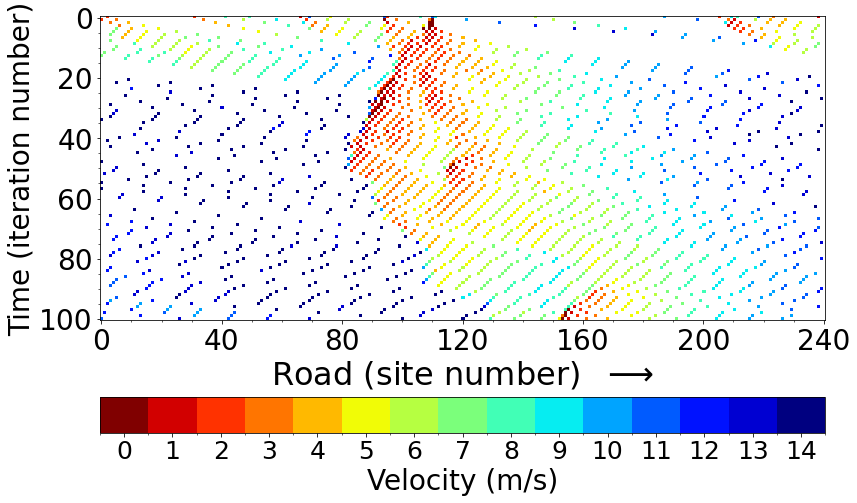

In [7]:
# Simulation parameters
random.seed(12345)
region_lengths = [240]
region_speed_limits = [14]
n_cars = int(240/12)
nt = 500
car_slow_down_prob = 0.127
traffic_light_list = []

# Perform the simulation
sim_plot = simulate_traffic_lights(region_lengths, region_speed_limits, 
                                   n_cars, nt, car_slow_down_prob, traffic_light_list)

# Create the plot
xticks = [0, 40, 80, 120, 160, 200, 240]
fig, ax = plt.subplots(figsize = (13, 14))
plot_road_with_lights(roads=sim_plot[0], traffic_light_roads=sim_plot[1], light_positions=[], 
                      limit_boundaries=[], vmax=region_speed_limits[0], nt=nt, 
                       xlim = [-0.5, 240.5], ylim = [100.5, -0.5], filename = "toy_model.pdf",
                    xticks = xticks)

The code below loads .npy objects as running multiple simulations to average results has expensive computational costs in terms of time. This was stored to be loaded for ease of analysing results and presenting plots.

## Validating the full model and analysis of varying parameters

### Varying Road Lengths

In [8]:
# Flow rates for various road lengths
FR_L = []
FR_L.append(np.load("sim_data/road_len/fr_20.npy"))
FR_L.append(np.load("sim_data/road_len/fr_100.npy"))
FR_L.append(np.load("sim_data/road_len/fr_450.npy"))
FR_L.append(np.load("sim_data/road_len/fr_900.npy"))
FR_L.append(np.load("sim_data/road_len/fr_2000.npy"))

# SPIs for various road lengths
SPI_L = []
SPI_L.append(np.load("sim_data/road_len/spi_20.npy")*100)
SPI_L.append(np.load("sim_data/road_len/spi_100.npy")*100)
SPI_L.append(np.load("sim_data/road_len/spi_450.npy")*100)
SPI_L.append(np.load("sim_data/road_len/spi_900.npy")*100)
SPI_L.append(np.load("sim_data/road_len/spi_2000.npy")*100)

# Calculate means and variances from the multiple simulation runs
means_fr_L,vars_fr_L = calculate_mean_var(FR_L)
means_spi_L, vars_spi_L = calculate_mean_var(SPI_L)

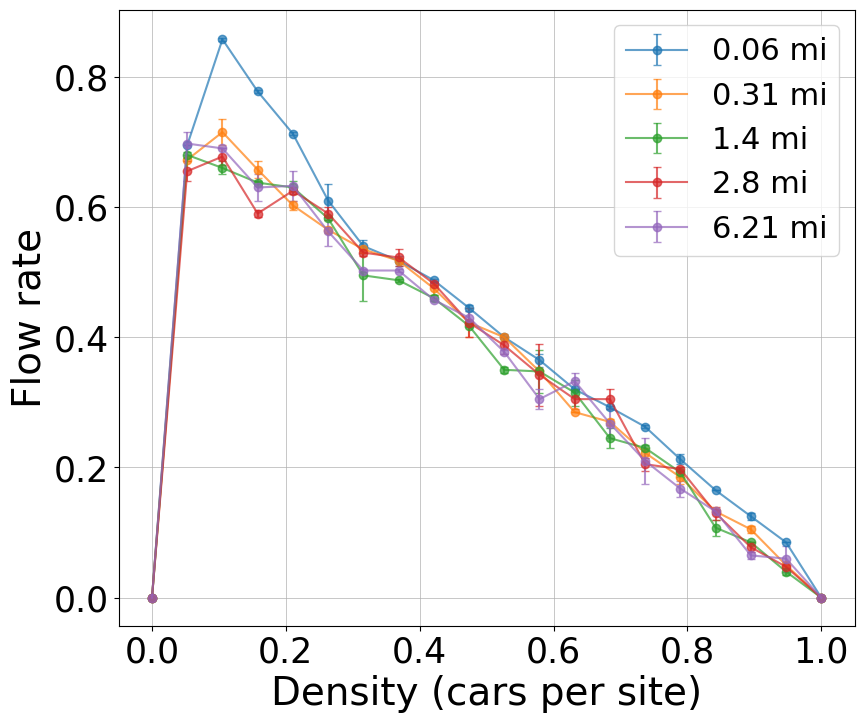

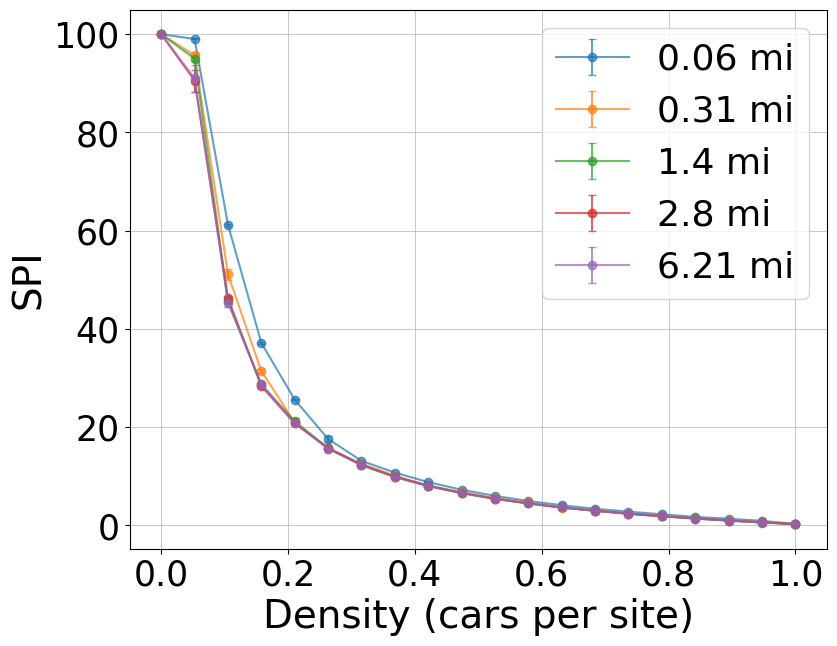

In [43]:
# Plot FR vs density and SPI vs density
data_points = 20
road_lengths = [20, 100, 450, 900, 2000]
road_length_labels = ["0.06 mi", "0.31 mi", "1.4 mi", "2.8 mi", "6.21 mi"]

# Plot line plot with error bars representing variance for flow rates
plt.figure(figsize=(9.5,8))
for i, mean in enumerate(means_fr_L):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_fr_L[i] )[::offset], alpha=0.7, fmt='-o', 
                 label=f'{road_length_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("Flow rate", fontsize = 28)
plt.tick_params("both", labelsize = 25)
plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)
plt.savefig("validate_road_len_FR.pdf", dpi = 300)

# Plot line plot with error bars representing variance for SPIs
plt.figure(figsize=(9, 7))
for i, mean in enumerate(means_spi_L):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar(np.linspace(0, 1, data_points)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_spi_L[i] )[::offset] , alpha=0.7, fmt='-o', 
                 label=f'{road_length_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("SPI", fontsize = 28)
plt.tick_params("both", labelsize = 25)
plt.legend(fontsize = 26)
plt.grid(which='both', linewidth=0.5)

### Varying number of iterations

In [10]:
# Flow rates for various number of iterations
FR_nt = []
FR_nt.append(np.load("sim_data/time_step/fr_50.npy"))
FR_nt.append(np.load("sim_data/time_step/fr_100.npy"))
FR_nt.append(np.load("sim_data/time_step/fr_200.npy"))
FR_nt.append(np.load("sim_data/time_step/fr_300.npy"))

# SPIs for various number of iterations
SPI_nt = []
SPI_nt.append(np.load("sim_data/time_step/spi_50.npy")*100)
SPI_nt.append(np.load("sim_data/time_step/spi_100.npy")*100)
SPI_nt.append(np.load("sim_data/time_step/spi_200.npy")*100)
SPI_nt.append(np.load("sim_data/time_step/spi_300.npy")*100)

# Calculate means and variances from the multiple simulation runs
means_fr_nt,vars_fr_nt = calculate_mean_var(FR_nt)
means_spi_nt, vars_spi_nt = calculate_mean_var(SPI_nt)

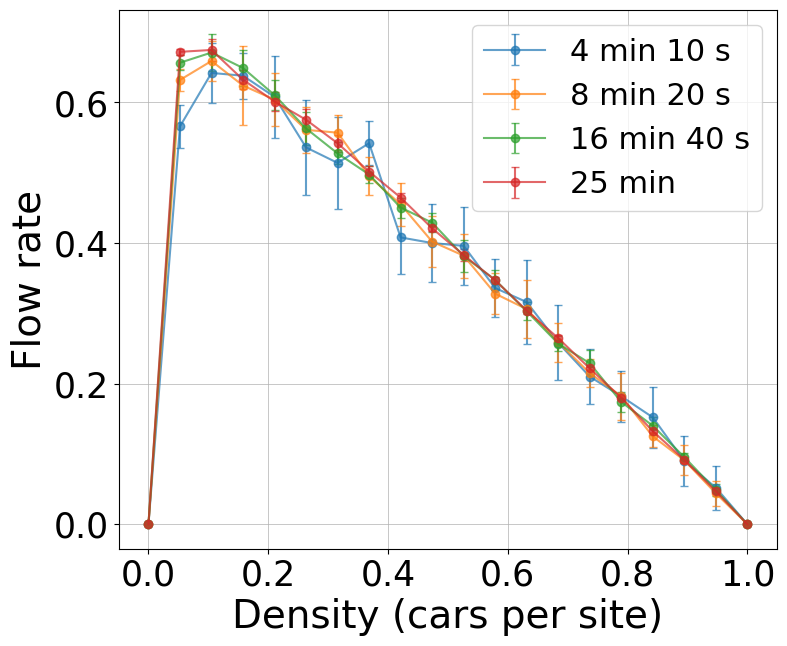

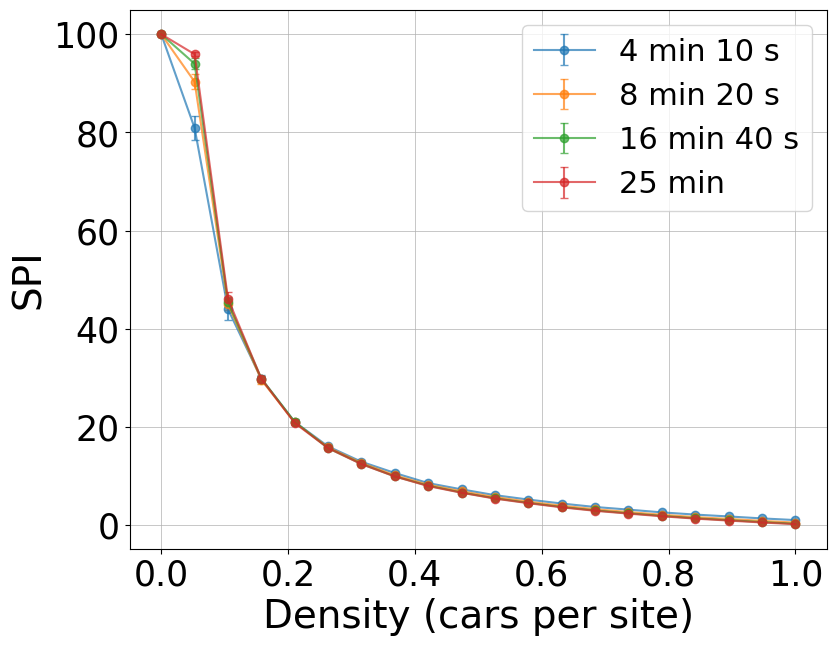

In [11]:
# Plot FR vs density and SPI vs density
data_points = 20
nts = [50, 100, 200, 300]
time_period_labels = ["4 min 10 s", "8 min 20 s", "16 min 40 s", 
                       "25 min"]

# Plot line plot with error bars representing variance for FRs
plt.figure(figsize=(8.5,7))
for i, mean in enumerate(means_fr_nt):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_fr_nt[i] )[::offset], alpha=0.7, fmt='-o', 
                 label=f'{time_period_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("Flow rate", fontsize = 28)
plt.tick_params("both", labelsize = 25)
plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)
plt.savefig("validate_nt_FR.pdf", dpi = 300)




# Plot line plot with error bars representing variance for SPIs
plt.figure(figsize=(9,7))
for i, mean in enumerate(means_spi_nt):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar(np.linspace(0, 1, data_points)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_spi_nt[i] )[::offset] , alpha=0.7, fmt='-o', 
                 label=f'{time_period_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("SPI", fontsize = 28)
plt.tick_params("both", labelsize = 25)
plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)

### Varying probability of random deceleration

In [12]:
# Flow rates for various probabilities
FR_prob = []
FR_prob.append(np.load("sim_data/prob/fr_0.npy"))
FR_prob.append(np.load("sim_data/prob/fr_0_2.npy"))
FR_prob.append(np.load("sim_data/prob/fr_0_4.npy"))
FR_prob.append(np.load("sim_data/prob/fr_0_6.npy"))
FR_prob.append(np.load("sim_data/prob/fr_0_8.npy"))

# SPIs for various probabilities
SPI_prob = []
SPI_prob.append(np.load("sim_data/prob/spi_0.npy")*100)
SPI_prob.append(np.load("sim_data/prob/spi_0_2.npy")*100)
SPI_prob.append(np.load("sim_data/prob/spi_0_4.npy")*100)
SPI_prob.append(np.load("sim_data/prob/spi_0_6.npy")*100)
SPI_prob.append(np.load("sim_data/prob/spi_0_8.npy")*100)

# Calculate means and variances from the multiple simulation runs
means_fr_prob,vars_fr_prob = calculate_mean_var(FR_prob)
means_spi_prob, vars_spi_prob = calculate_mean_var(SPI_prob)

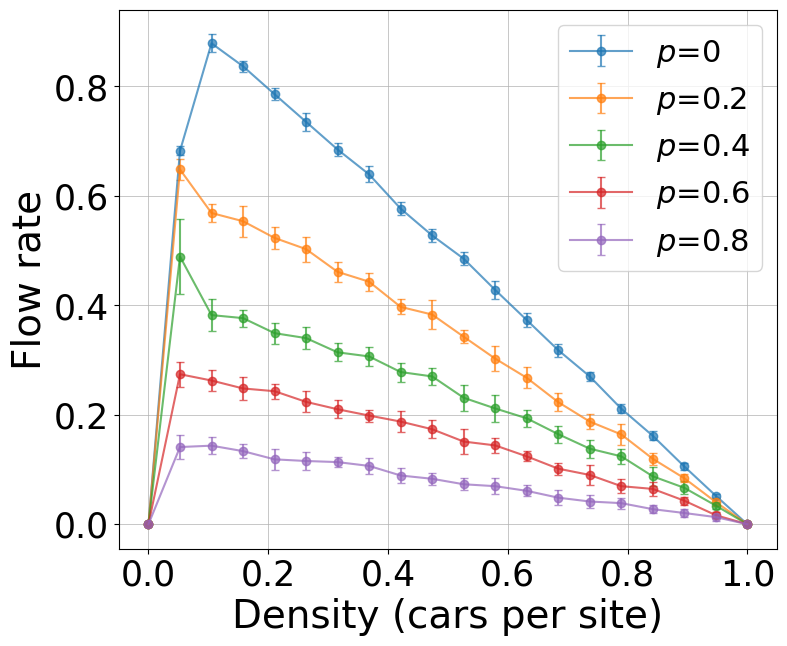

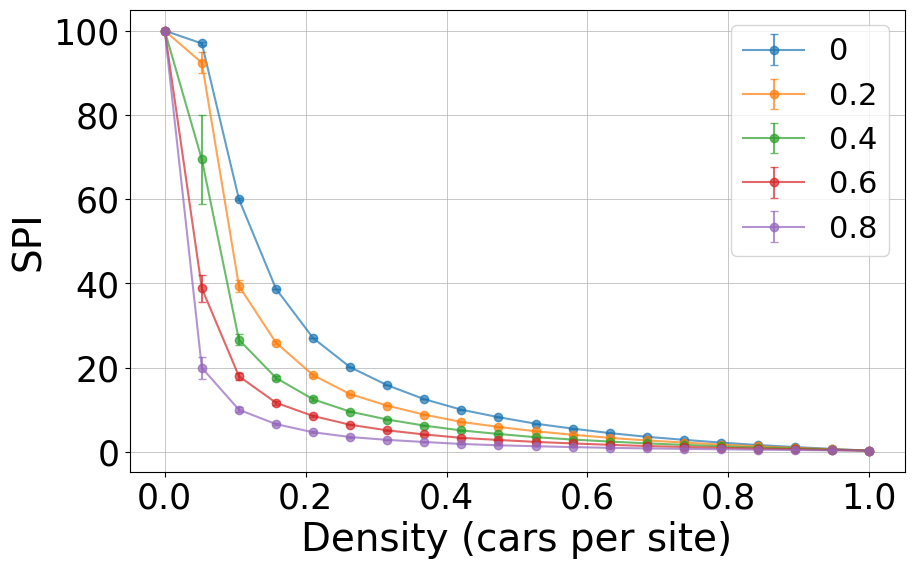

In [13]:
# Plot FR vs density and SPI vs density
data_points = 20
probability_labels = [0, 0.2, 0.4, 0.6, 0.8]

# Plot line plot with error bars representing variance for FRs
plt.figure(figsize=(8.5,7))
for i, mean in enumerate(means_fr_prob):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_fr_prob[i] )[::offset], alpha=0.7, fmt='-o', 
                 label=f'$p$={probability_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("Flow rate", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)
plt.savefig("validate_prob_FR.pdf", dpi = 300)

# Plot line plot with error bars representing variance for SPIs
plt.figure(figsize=(10, 6))
for i, mean in enumerate(means_spi_prob):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar(np.linspace(0, 1, data_points)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_spi_prob[i] )[::offset] , alpha=0.7, fmt='-o', 
                 label=f'{probability_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("SPI", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)

### Varying the speed limits across the road

In [14]:
# Flow rates for various speed limits
FR_speed_lims = []
FR_speed_lims.append(np.load("sim_data/speed_lims/fr_9.npy"))
FR_speed_lims.append(np.load("sim_data/speed_lims/fr_14.npy"))
FR_speed_lims.append(np.load("sim_data/speed_lims/fr_23.npy"))
FR_speed_lims.append(np.load("sim_data/speed_lims/fr_27.npy"))
FR_speed_lims.append(np.load("sim_data/speed_lims/fr_32.npy"))

# SPIs for various speed limits
SPI_speed_lims = []
SPI_speed_lims.append(np.load("sim_data/speed_lims/spi_9.npy")*100)
SPI_speed_lims.append(np.load("sim_data/speed_lims/spi_14.npy")*100)
SPI_speed_lims.append(np.load("sim_data/speed_lims/spi_23.npy")*100)
SPI_speed_lims.append(np.load("sim_data/speed_lims/spi_27.npy")*100)
SPI_speed_lims.append(np.load("sim_data/speed_lims/spi_32.npy")*100)

# Calculate means and variances from the multiple simulation runs
means_fr_speed_lims,vars_fr_speed_lims = calculate_mean_var(FR_speed_lims)
means_spi_speed_lims, vars_spi_speed_lims = calculate_mean_var(SPI_speed_lims)

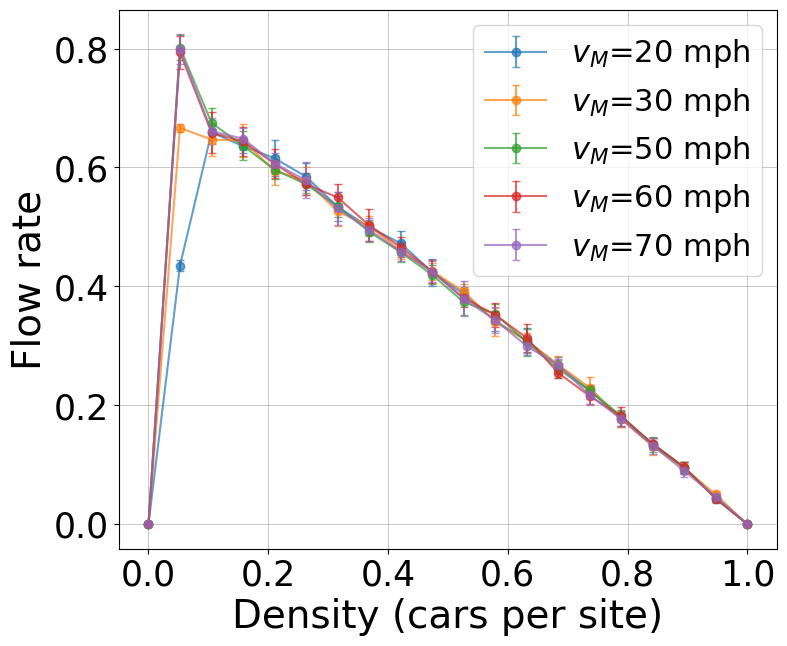

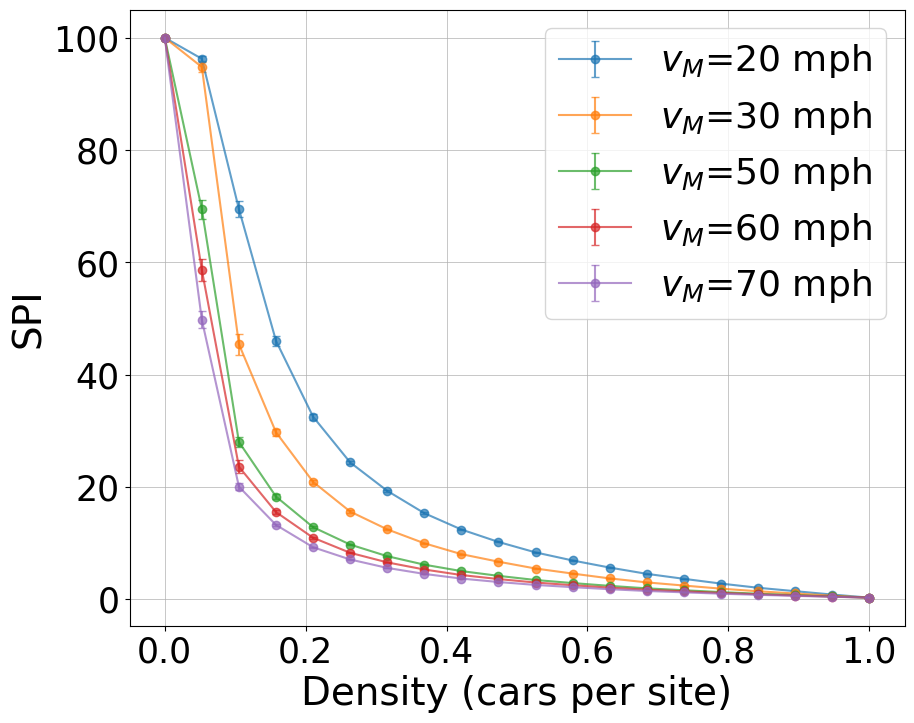

In [42]:
# Plot FR vs density and SPI vs density
data_points = 20
speed_lim_labels = ["20 mph", "30 mph", "50 mph", "60 mph", "70 mph"]

# Plot line plot with error bars representing variance for FRs
plt.figure(figsize=(8.5,7))
for i, mean in enumerate(means_fr_speed_lims):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_fr_speed_lims[i] )[::offset], alpha=0.7, fmt='-o', 
                 label=f'$v_M$={speed_lim_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("Flow rate", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)

# Plot line plot with error bars representing variance for SPIs
plt.figure(figsize=(10, 8))
for i, mean in enumerate(means_spi_speed_lims):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar(np.linspace(0, 1, data_points)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_spi_speed_lims[i] )[::offset] , alpha=0.7, fmt='-o', 
                 label=f'$v_M$={speed_lim_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("SPI", fontsize = 28)
plt.tick_params("both", labelsize = 25)
plt.legend(fontsize = 26)
plt.grid(which='both', linewidth=0.5)
plt.savefig("validate_speed_lims_SPI.pdf", dpi = 300)

## Implementing the full model on a real road network (York Road, Leeds, UK)

In this section, we implement our model which includes traffic lights as well as variable speed limits on a section of York Road in Leeds, UK. 

Having inspected the road via satellite navigators, the traffic lights on this road are given as follows:
1. Crossing at 304m (61)
2. Crossing at 967m (193)
3. Controlled light at 1,360m (272)
4. Crossing at 2,820m (564)
5. Controlled at 3,300m (660)
6. Controlled at 3,360m (672)
7. Controlled at 3,520m (704)
8. Crossing at 3,620m (724)
9. Controlled at 3,700m (740)
10. Crossing at 4,000m (800)
11. Controlled at 4,130m (826)
12. Controlled at 4,280m (855)

The original speed limits on the road change at the 700m mark, from 30mph to 40mph. We propose one initial change to the road by reducing the speed limit as traffic approaches the sets of lights near the end of our road, from 40mph to 30mph again. 

The flow rate = 0.38
 The average SPI per iteration = 0.23785418777440054


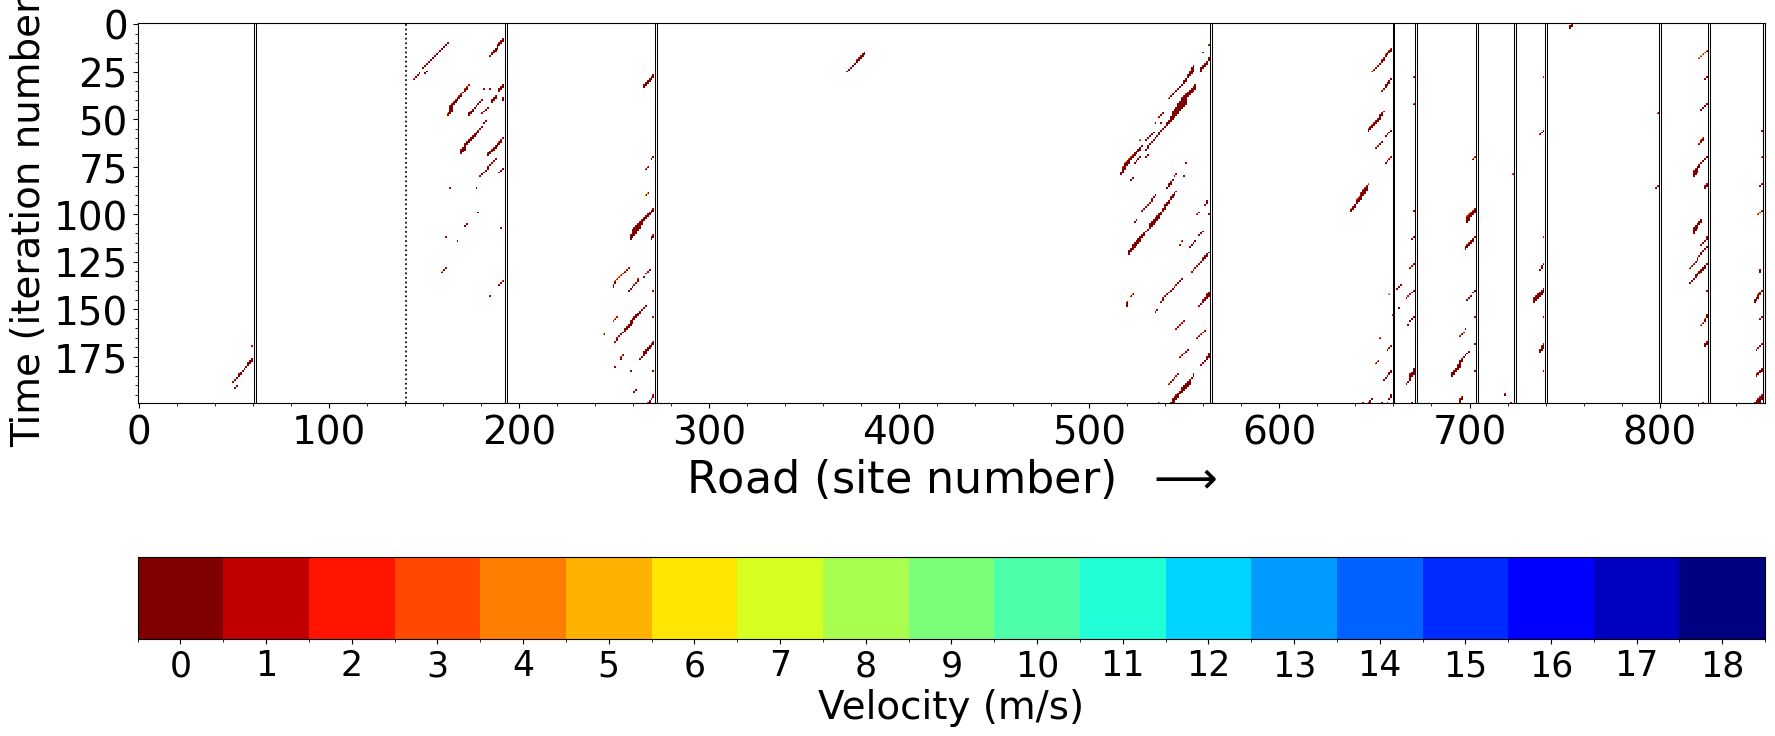

In [16]:
random.seed(12345)
region_lengths = [140, 716]
limit_boundaries = [140]
region_speed_limits = [14, 18]
n_cars = 94
nt = 200
car_slow_down_prob = 0.127
red_time = 2
green_time = red_time + 12
light_positions = [61, 193, 272, 564, 660, 672, 704, 724, 740, 800, 826, 855]
traffic_light_list = [
    (61, green_time, red_time, 0, True),
    (193, green_time, red_time, 0, True),
    (272, green_time, red_time, 0, False),
    (564, green_time, red_time, 0, True),
    (660, green_time, red_time, 0, False),
    (672, green_time, red_time, 0, False),
    (704, green_time, red_time, 0, False),
    (724, green_time, red_time, 0, True),
    (740, green_time, red_time, 0, False),
    (800, green_time, red_time, 0, True),
    (826, green_time, red_time, 0, False),
    (855, green_time, red_time, 0, False)
    ]

sim_york_rd_val = simulate_traffic_lights(region_lengths, region_speed_limits, 
                                     n_cars, nt, car_slow_down_prob, 
                                     traffic_light_list)

print(f"The flow rate = {sim_york_rd_val[2]}\n",
      f"The average SPI per iteration = {sim_york_rd_val[3]}")
fig, ax = plt.subplots(figsize = (21,20))
plot_road_with_lights(roads = sim_york_rd_val[0], traffic_light_roads = sim_york_rd_val[1], 
                      light_positions = light_positions, limit_boundaries = limit_boundaries, 
                      vmax = max(region_speed_limits), nt = nt)

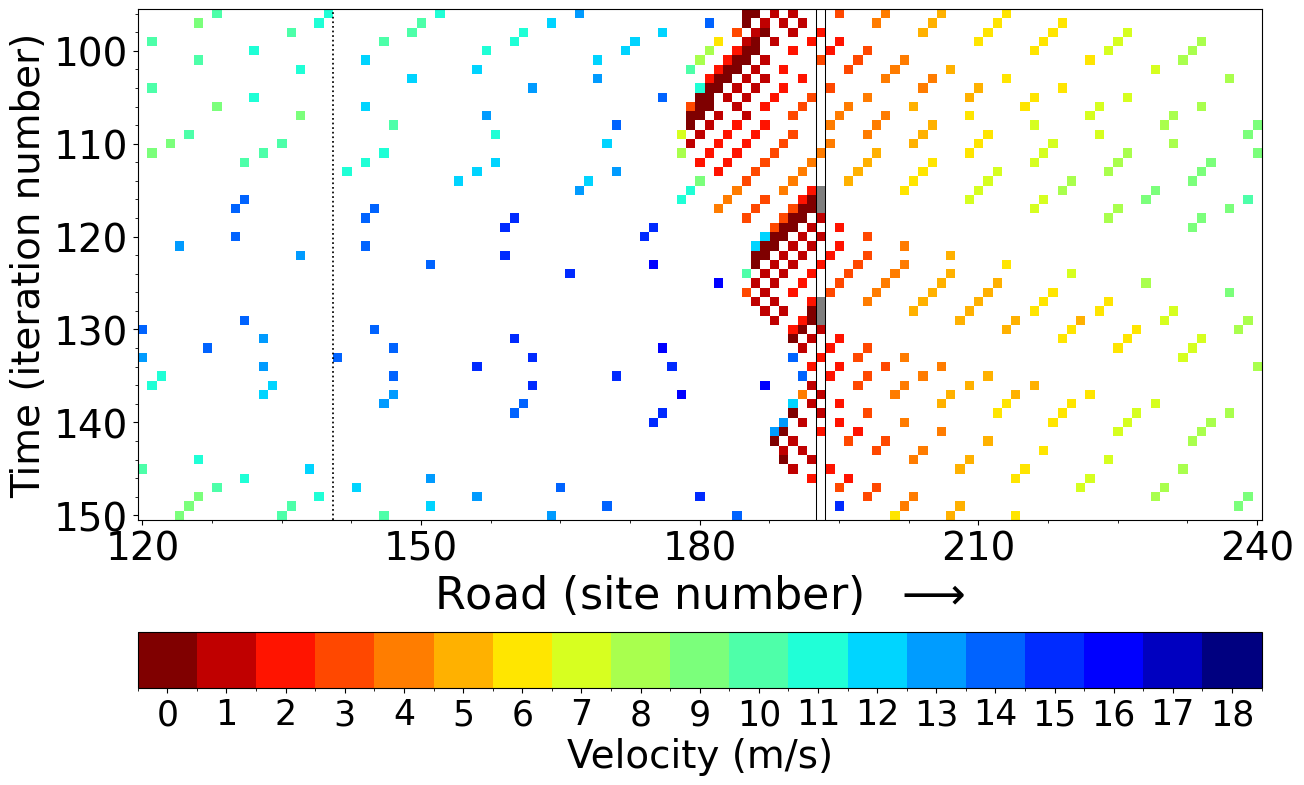

In [17]:
random.seed(12345)
region_lengths = [140, 716]
limit_boundaries = [140]
region_speed_limits = [14, 18]

n_cars = int(sum(region_lengths)/10)
nt = 200
car_slow_down_prob = 0.127
red_time = 2
green_time = red_time + 12
light_positions = [61, 193, 272, 564, 660, 672, 704, 724, 740, 800, 826, 855]
traffic_light_list = [
    (61, green_time, red_time, 0, True),
    (193, green_time, red_time, 0, True),
    (272, green_time, red_time, 0, False),
    (564, green_time, red_time, 0, True),
    (660, green_time, red_time, 0, False),
    (672, green_time, red_time, 0, False),
    (704, green_time, red_time, 0, False),
    (724, green_time, red_time, 0, True),
    (740, green_time, red_time, 0, False),
    (800, green_time, red_time, 0, True),
    (826, green_time, red_time, 0, False),
    (855, green_time, red_time, 0, False)
    ]

sim_york_rd = simulate_traffic_lights(region_lengths, region_speed_limits, 
                                     n_cars, nt, car_slow_down_prob, 
                                     traffic_light_list)

xticks = [120, 150, 180, 210, 240]
fig, ax = plt.subplots(figsize = (14.5, 14.5))
plot_road_with_lights(roads = sim_york_rd[0], traffic_light_roads = sim_york_rd[1], 
                      light_positions = light_positions, limit_boundaries = limit_boundaries, 
                      vmax = max(region_speed_limits), nt = nt,
                      ylim = [150.5, 95.5], xlim = [119.5, 240.5], xticks = xticks,
                      filename="traffic_model.pdf")

### Base Case

Below is the code for the base case, modelled on York Road. This removes all traffic lights and allows for a consistent speed limit (here we've chosen the one that's present on majority of the road, i.e. 40mph) along the entire road. 

In [18]:
# FR and SPI for base case
FR_base_240 = np.load("sim_data/yk_240/fr_1.npy")
SPI_base_240 = np.load("sim_data/yk_240/spi_1.npy")*100
FR_base_856 = np.load("sim_data/yk_856/fr_1.npy")
SPI_base_856 = np.load("sim_data/yk_856/spi_1.npy")*100

### Varying red cycle times

Here, we analyse the effect of density on flow rates and SPI when we consider a single traffic light on the road and vary the time period of a red signal.

In [19]:
# FRs for various red cycle times
FR_red_time = [FR_base_240]
FR_red_time.append(np.load("sim_data/red_time/fr_2.npy"))
FR_red_time.append(np.load("sim_data/red_time/fr_4.npy"))
FR_red_time.append(np.load("sim_data/red_time/fr_6.npy"))
FR_red_time.append(np.load("sim_data/red_time/fr_8.npy"))
FR_red_time.append(np.load("sim_data/red_time/fr_11.npy"))

# SPIs for various red cycle times
SPI_red_time = [SPI_base_240]
SPI_red_time.append(np.load("sim_data/red_time/spi_2.npy")*100)
SPI_red_time.append(np.load("sim_data/red_time/spi_4.npy")*100)
SPI_red_time.append(np.load("sim_data/red_time/spi_6.npy")*100)
SPI_red_time.append(np.load("sim_data/red_time/spi_8.npy")*100)
SPI_red_time.append(np.load("sim_data/red_time/spi_11.npy")*100)

# Calculate means and variances from the multiple simulation runs
means_fr_red_time,vars_fr_red_time = calculate_mean_var(FR_red_time)
means_spi_red_time, vars_spi_red_time = calculate_mean_var(SPI_red_time)

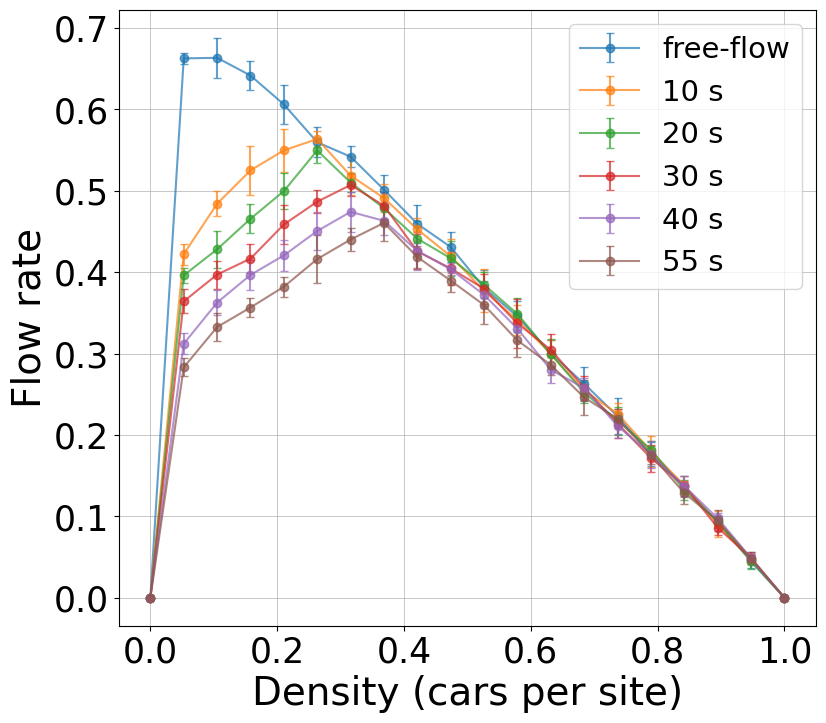

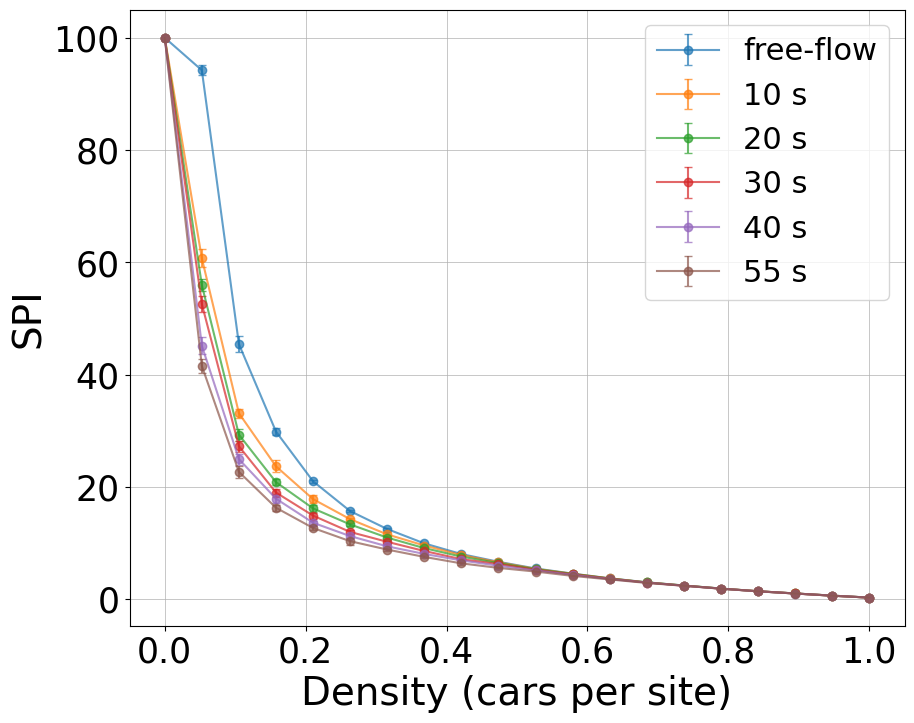

In [20]:
# Plot FR vs density and SPI vs density
data_points = 20
red_times = [2, 4, 6, 8, 11] # red cycle times
red_time_labels = ["free-flow", "10 s", "20 s", "30 s", "40 s", "55 s"]

# Plot line plot with error bars representing variance for FRs
plt.figure(figsize=(9,8))
for i, mean in enumerate(means_fr_red_time):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_fr_red_time[i] )[::offset], alpha=0.7, fmt='-o', 
                 label=f'{red_time_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("Flow rate", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 21)
plt.grid(which='both', linewidth=0.5)
plt.savefig("red_time_FR.pdf", dpi = 300)

# Plot line plot with error bars representing variance for SPIs
plt.figure(figsize=(10,8))
for i, mean in enumerate(means_spi_red_time):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar(np.linspace(0, 1, data_points)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_spi_red_time[i] )[::offset] , alpha=0.7, fmt='-o', 
                 label=f'{red_time_labels[i]}', capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("SPI", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)
plt.savefig("red_time_SPI.pdf", dpi = 300)

### Varying green cycle times

Here, we analyse the effect of density on flow rates and SPI when we consider a single traffic light on the road and vary the time period of a green signal.

In [21]:
# FRs for various green cycle times
FR_green_time = [FR_base_240]
FR_green_time.append(np.load("sim_data/green_time/fr_10.npy"))
FR_green_time.append(np.load("sim_data/green_time/fr_15.npy"))
FR_green_time.append(np.load("sim_data/green_time/fr_20.npy"))
FR_green_time.append(np.load("sim_data/green_time/fr_25.npy"))
FR_green_time.append(np.load("sim_data/green_time/fr_31.npy"))

# SPIs for various green cycle times
SPI_green_time = [SPI_base_240]
SPI_green_time.append(np.load("sim_data/green_time/spi_10.npy")*100)
SPI_green_time.append(np.load("sim_data/green_time/spi_15.npy")*100)
SPI_green_time.append(np.load("sim_data/green_time/spi_20.npy")*100)
SPI_green_time.append(np.load("sim_data/green_time/spi_25.npy")*100)
SPI_green_time.append(np.load("sim_data/green_time/spi_31.npy")*100)

# Calculate means and variances from the multiple simulation runs
means_fr_green_time,vars_fr_green_time = calculate_mean_var(FR_green_time)
means_spi_green_time, vars_spi_green_time = calculate_mean_var(SPI_green_time)

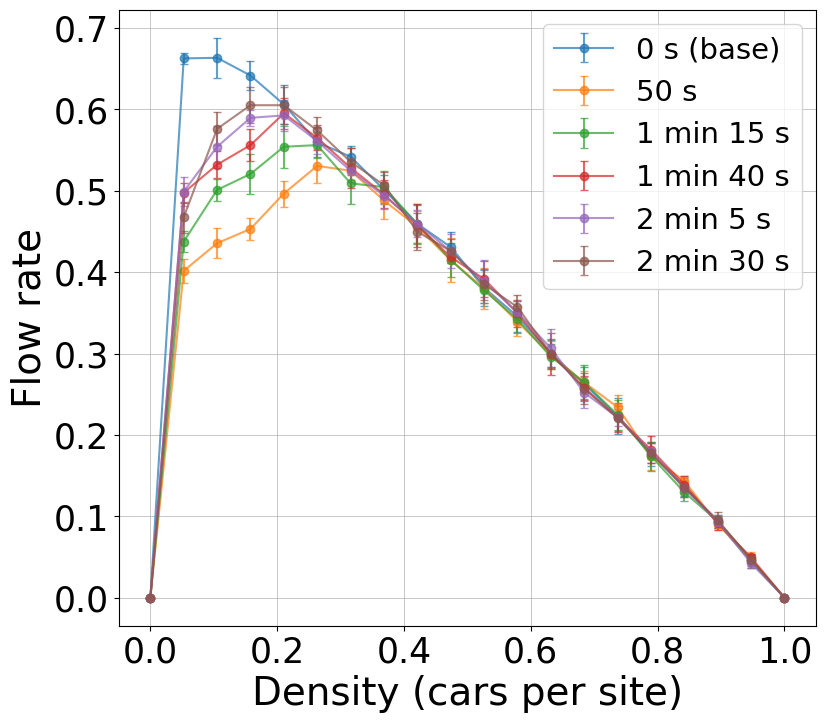

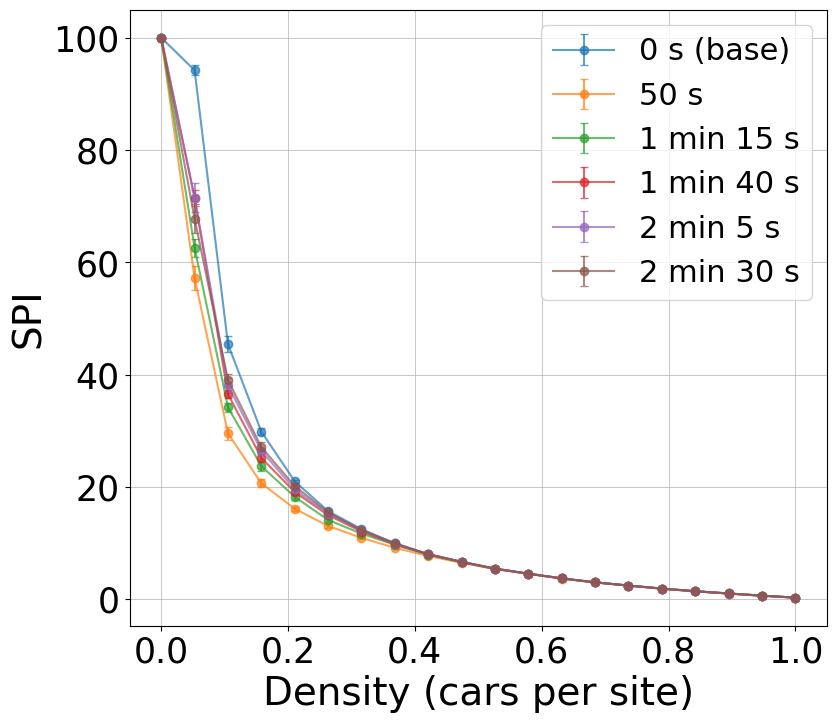

In [22]:
# Plot FR vs density and SPI vs density
data_points = 20
green_times = [10, 15, 20, 25, 30] # green cycle times
green_time_labels = ["0 s (base)", "50 s", "1 min 15 s", "1 min 40 s", "2 min 5 s", "2 min 30 s"]

# Plot line plot with error bars representing variance for FRs
plt.figure(figsize=(9,8))
for i, mean in enumerate(means_fr_green_time):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_fr_green_time[i] )[::offset], alpha=0.7, fmt='-o', 
                 label=f'{green_time_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("Flow rate", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 21)
plt.grid(which='both', linewidth=0.5)
plt.savefig("green_time_FR.pdf", dpi = 300)



# Plot line plot with error bars representing variance for SPIs
plt.figure(figsize=(9,8))
for i, mean in enumerate(means_spi_green_time):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar(np.linspace(0, 1, data_points)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_spi_green_time[i] )[::offset] , alpha=0.7, fmt='-o', 
                 label=f'{green_time_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("SPI", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)
plt.savefig("green_time_SPI.pdf", dpi = 300)

### Varying position of a single traffic light on the road

Here, we analyse the effect of density on flow rates and SPI when we consider a single traffic light on the road and vary the position of the traffic light on the road.

In [23]:
# FRs for various positions of a single traffic light
FR_1TL = [FR_base_240]
FR_1TL.append(np.load("sim_data/var_tl/fr_0.npy"))
FR_1TL.append(np.load("sim_data/var_tl/fr_59.npy"))
FR_1TL.append(np.load("sim_data/var_tl/fr_119.npy"))
FR_1TL.append(np.load("sim_data/var_tl/fr_179.npy"))
FR_1TL.append(np.load("sim_data/var_tl/fr_239.npy"))

# SPIs for various positions of a single traffic light
SPI_1TL = [SPI_base_240]
SPI_1TL.append(np.load("sim_data/var_tl/spi_0.npy")*100)
SPI_1TL.append(np.load("sim_data/var_tl/spi_59.npy")*100)
SPI_1TL.append(np.load("sim_data/var_tl/spi_119.npy")*100)
SPI_1TL.append(np.load("sim_data/var_tl/spi_179.npy")*100)
SPI_1TL.append(np.load("sim_data/var_tl/spi_239.npy")*100)

# Calculate means and variances from the multiple simulation runs
means_fr_1TL,vars_fr_1TL = calculate_mean_var(FR_1TL)
means_spi_1TL, vars_spi_1TL = calculate_mean_var(SPI_1TL)

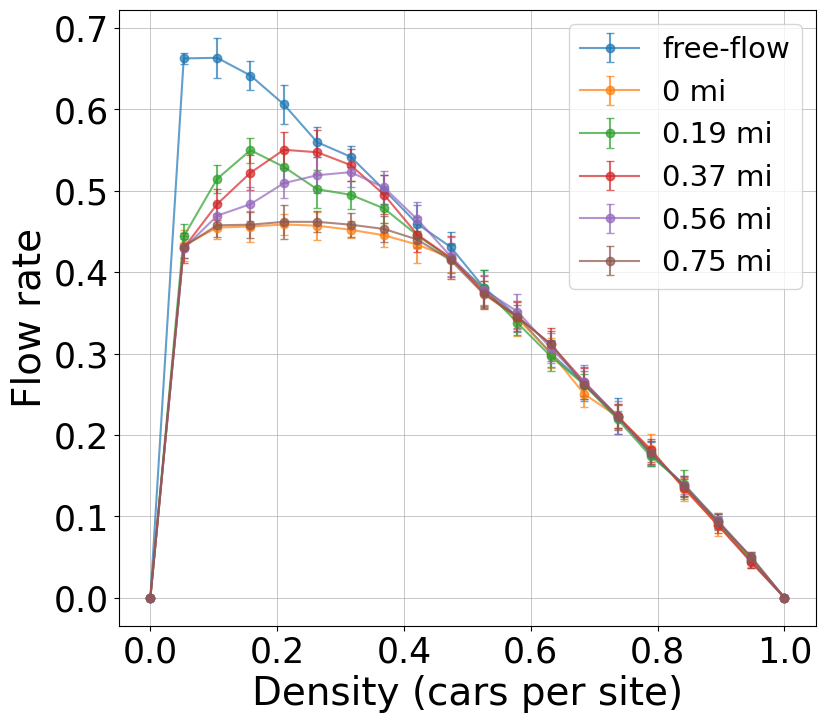

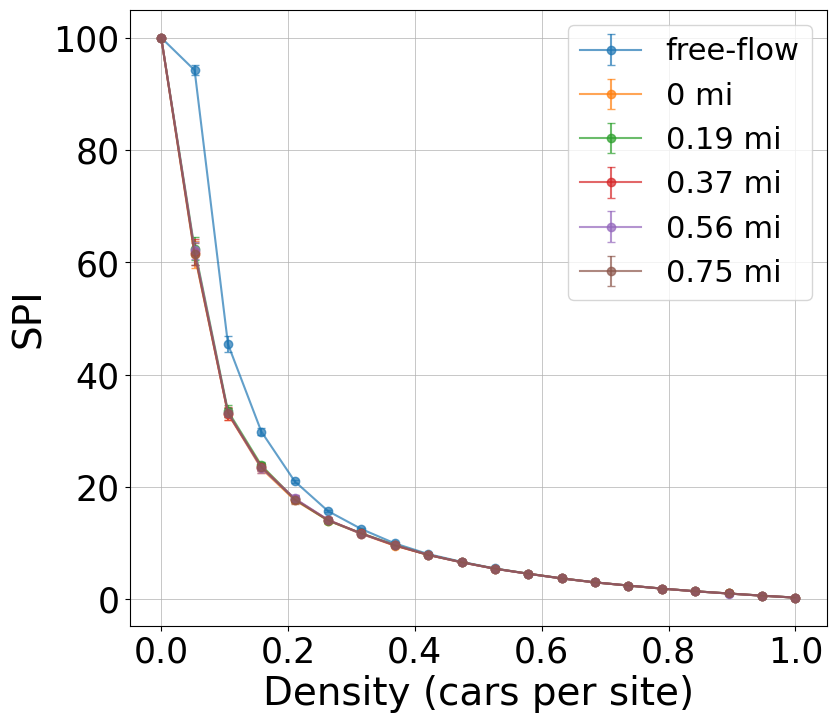

In [24]:
# Plot FR vs density and SPI vs density
data_points = 20
one_TL = [0, 59, 119, 179, 239] # number of simulation steps
var_TL_labels = ["free-flow", "0 mi", "0.19 mi", "0.37 mi", "0.56 mi", "0.75 mi"]

# Plot line plot with error bars representing variance for FRs
plt.figure(figsize=(9,8))
for i, mean in enumerate(means_fr_1TL):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_fr_1TL[i] )[::offset], alpha=0.7, fmt='-o', 
                 label=f'{var_TL_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("Flow rate", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 21)
plt.grid(which='both', linewidth=0.5)
plt.savefig("one_TL_FR.pdf", dpi = 300)



# Plot line plot with error bars representing variance for SPIs
plt.figure(figsize=(9,8))
for i, mean in enumerate(means_spi_1TL):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar(np.linspace(0, 1, data_points)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_spi_1TL[i] )[::offset] , alpha=0.7, fmt='-o', 
                 label=f'{var_TL_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("SPI", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)
plt.savefig("one_TL_SPI.pdf", dpi = 300)

### Varying distance between two traffic lights

Here, we analyse the effect of density on flow rates and SPI when we consider two traffic lights on the road and vary the distance between the two traffic lights.

In [25]:
# FRs for various distances between the two traffic lights
FR_2TL = [FR_base_240]
FR_2TL.append(np.load("sim_data/var_2tl/fr_60.npy"))
FR_2TL.append(np.load("sim_data/var_2tl/fr_90.npy"))
FR_2TL.append(np.load("sim_data/var_2tl/fr_120.npy"))
FR_2TL.append(np.load("sim_data/var_2tl/fr_150.npy"))
FR_2TL.append(np.load("sim_data/var_2tl/fr_181.npy"))

# SPIs for various distances between the two traffic lights
SPI_2TL = [SPI_base_240]
SPI_2TL.append(np.load("sim_data/var_2tl/spi_60.npy")*100)
SPI_2TL.append(np.load("sim_data/var_2tl/spi_90.npy")*100)
SPI_2TL.append(np.load("sim_data/var_2tl/spi_120.npy")*100)
SPI_2TL.append(np.load("sim_data/var_2tl/spi_150.npy")*100)
SPI_2TL.append(np.load("sim_data/var_2tl/spi_181.npy")*100)

# Calculate means and variances from the multiple simulation runs
means_fr_2TL,vars_fr_2TL = calculate_mean_var(FR_2TL)
means_spi_2TL, vars_spi_2TL = calculate_mean_var(SPI_2TL)

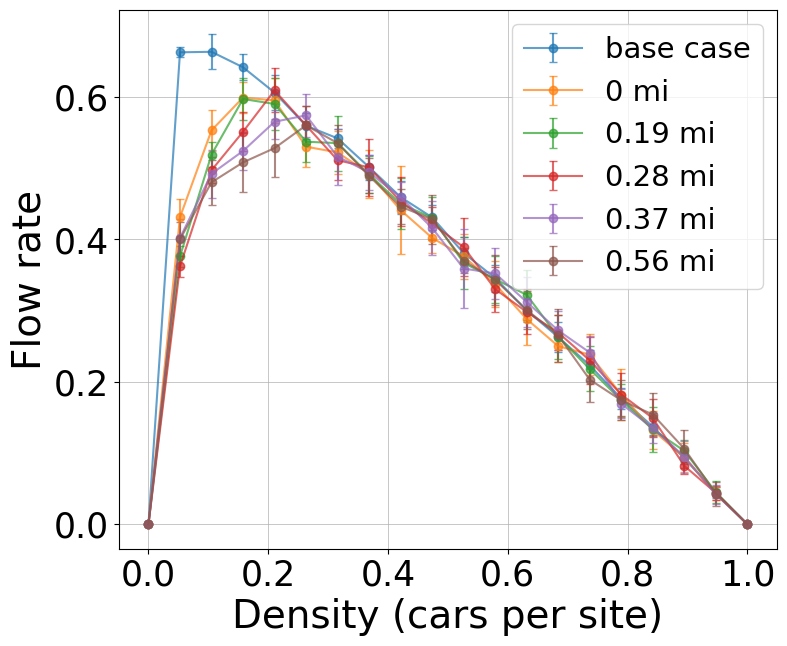

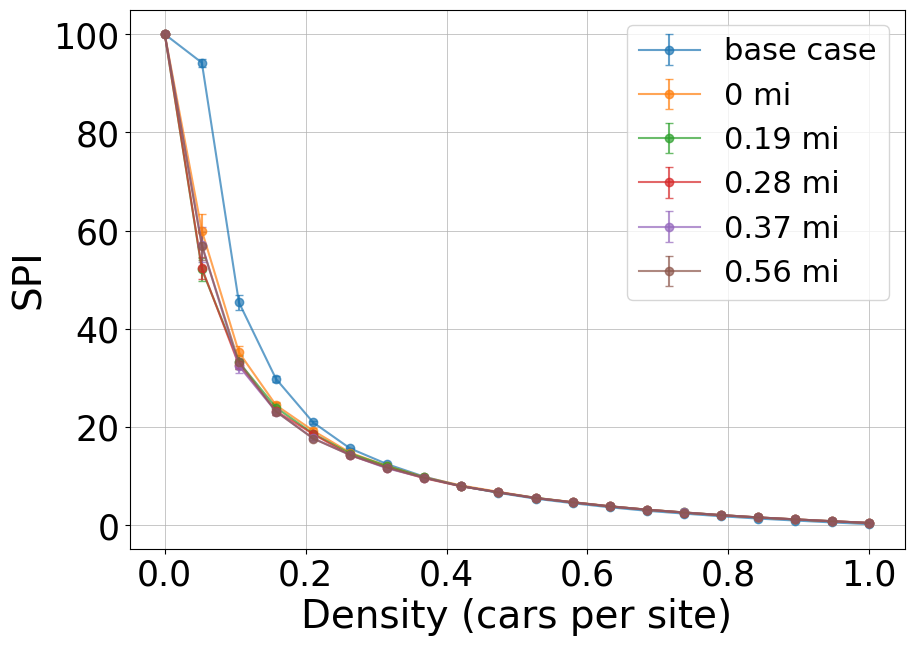

In [26]:
# Plot FR vs density and SPI vs density
data_points = 20
two_TL = [0, 60, 90, 120, 180] # number of simulation steps
two_TL_labels = ["base case", "0 mi", "0.19 mi", "0.28 mi", "0.37 mi", "0.56 mi"]

# Plot line plot with error bars representing variance for FRs
plt.figure(figsize=(8.5,7))
for i, mean in enumerate(means_fr_2TL):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_fr_2TL[i] )[::offset], alpha=0.7, fmt='-o', 
                 label=f'{two_TL_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("Flow rate", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 21)
plt.grid(which='both', linewidth=0.5)
plt.savefig("two_TL_FR.pdf", dpi = 300)



# Plot line plot with error bars representing variance for SPIs
plt.figure(figsize=(10,7))
for i, mean in enumerate(means_spi_2TL):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar(np.linspace(0, 1, data_points)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_spi_2TL[i] )[::offset] , alpha=0.7, fmt='-o', 
                 label=f'{two_TL_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("SPI", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)
plt.savefig("two_TL_SPI.pdf", dpi = 300)

### Varying the number of traffic lights on the road

Here, we analyse the effect of density on flow rates and SPI when we consider choosing different numbers of traffic lights on the road.

In [27]:
# FRs for various number of traffic lights
FR_mul_tl = [FR_base_856]
FR_mul_tl.append(np.load("sim_data/mul_tl/fr_[428].npy"))
FR_mul_tl.append(np.load("sim_data/mul_tl/fr_[214, 642].npy"))
FR_mul_tl.append(np.load("sim_data/mul_tl/fr_[143, 429, 715].npy"))
FR_mul_tl.append(np.load("sim_data/mul_tl/fr_[107, 321, 535, 749].npy"))
FR_mul_tl.append(np.load("sim_data/mul_tl/fr_[86, 258, 430, 602, 774].npy"))

# SPIs for various number of traffic lights
SPI_mul_tl = [SPI_base_856]
SPI_mul_tl.append(np.load("sim_data/mul_tl/spi_[428].npy")*100)
SPI_mul_tl.append(np.load("sim_data/mul_tl/spi_[214, 642].npy")*100)
SPI_mul_tl.append(np.load("sim_data/mul_tl/spi_[143, 429, 715].npy")*100)
SPI_mul_tl.append(np.load("sim_data/mul_tl/spi_[107, 321, 535, 749].npy")*100)
SPI_mul_tl.append(np.load("sim_data/mul_tl/spi_[86, 258, 430, 602, 774].npy")*100)

# Calculate means and variances from the multiple simulation runs
means_fr_mul_tl,vars_fr_mul_tl = calculate_mean_var(FR_mul_tl)
means_spi_mul_tl, vars_spi_mul_tl = calculate_mean_var(SPI_mul_tl)

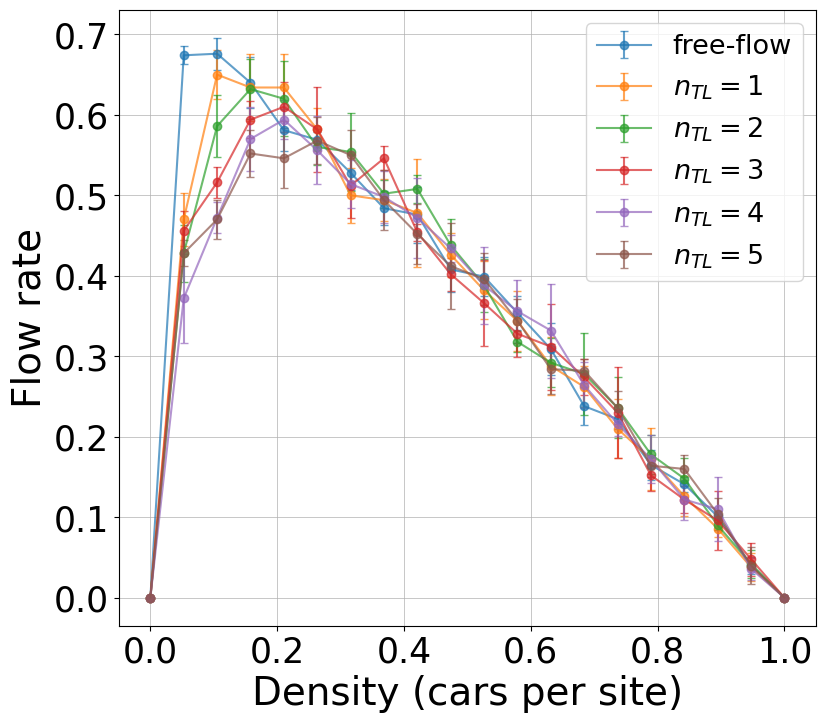

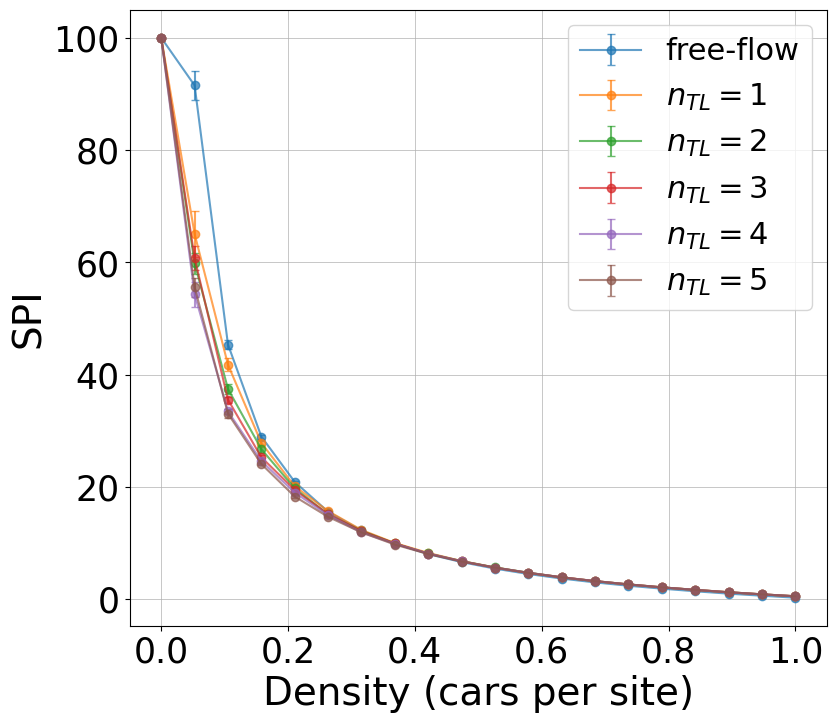

In [28]:
# Plot FR vs density and SPI vs density
data_points = 20
mul_TL_labels = ["free-flow", '$n_{TL}=$'+f'1', '$n_{TL}=$'+f'2', '$n_{TL}=$'+f'3', '$n_{TL}=$'+f'4', '$n_{TL}=$'+f'5'] # number of traffic lights

# Plot line plot with error bars representing variance for FRs
plt.figure(figsize=(9,8))
for i, mean in enumerate(means_fr_mul_tl):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_fr_mul_tl[i] )[::offset], alpha=0.7, fmt='-o', 
                 label=f'{mul_TL_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("Flow rate", fontsize = 28)
plt.tick_params("both", labelsize = 25)
plt.legend(fontsize = 19.5)
plt.grid(which='both', linewidth=0.5)
plt.savefig("mul_TL_FR.pdf", dpi = 300)


# Plot line plot with error bars representing variance for SPIs
plt.figure(figsize=(9,8))
for i, mean in enumerate(means_spi_mul_tl):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar(np.linspace(0, 1, data_points)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_spi_mul_tl[i] )[::offset] , alpha=0.7, fmt='-o', 
                 label=f'{mul_TL_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("SPI", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)
plt.savefig("mul_TL_SPI.pdf", dpi = 300)

### Varying speed limit boundaries surrounding a traffic light.
Consider a traffic light in the centre of a road with 856 sites. We allow the speed limit to change $x$ metres before and $x$ metres after the signal, where the speed limit closer to the signal will be lower than the speed limit away from the signal.
Here, we analyse the effect of density on flow rates and SPI when we consider a single traffic light on the road and vary the distance before and after which we vary the speed limit surrounding the traffic light.

In [30]:
# FRs for various speed limit boundary values
FR_var_speed = [FR_base_856]
FR_var_speed.append(np.load("sim_data/var_speed/fr_[428, 0, 428].npy"))
FR_var_speed.append(np.load("sim_data/var_speed/fr_[408, 40, 408].npy"))
FR_var_speed.append(np.load("sim_data/var_speed/fr_[388, 80, 388].npy"))
FR_var_speed.append(np.load("sim_data/var_speed/fr_[368, 120, 368].npy"))
FR_var_speed.append(np.load("sim_data/var_speed/fr_[348, 160, 348].npy"))
FR_var_speed.append(np.load("sim_data/var_speed/fr_[328, 200, 328].npy"))

# SPIs for various speed limit boundary values
SPI_var_speed = [SPI_base_856]
SPI_var_speed.append(np.load("sim_data/var_speed/spi_[428, 0, 428].npy")*100)
SPI_var_speed.append(np.load("sim_data/var_speed/spi_[408, 40, 408].npy")*100)
SPI_var_speed.append(np.load("sim_data/var_speed/spi_[388, 80, 388].npy")*100)
SPI_var_speed.append(np.load("sim_data/var_speed/spi_[368, 120, 368].npy")*100)
SPI_var_speed.append(np.load("sim_data/var_speed/spi_[348, 160, 348].npy")*100)
SPI_var_speed.append(np.load("sim_data/var_speed/spi_[328, 200, 328].npy")*100)

# Calculate means and variances from the multiple simulation runs
means_fr_var_speed,vars_fr_var_speed = calculate_mean_var(FR_var_speed)
means_spi_var_speed, vars_spi_var_speed = calculate_mean_var(SPI_var_speed)

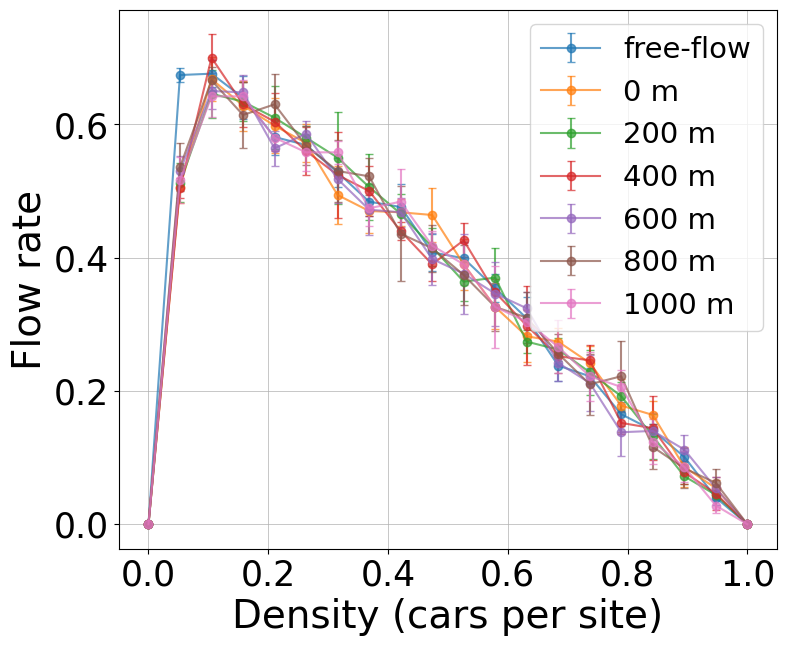

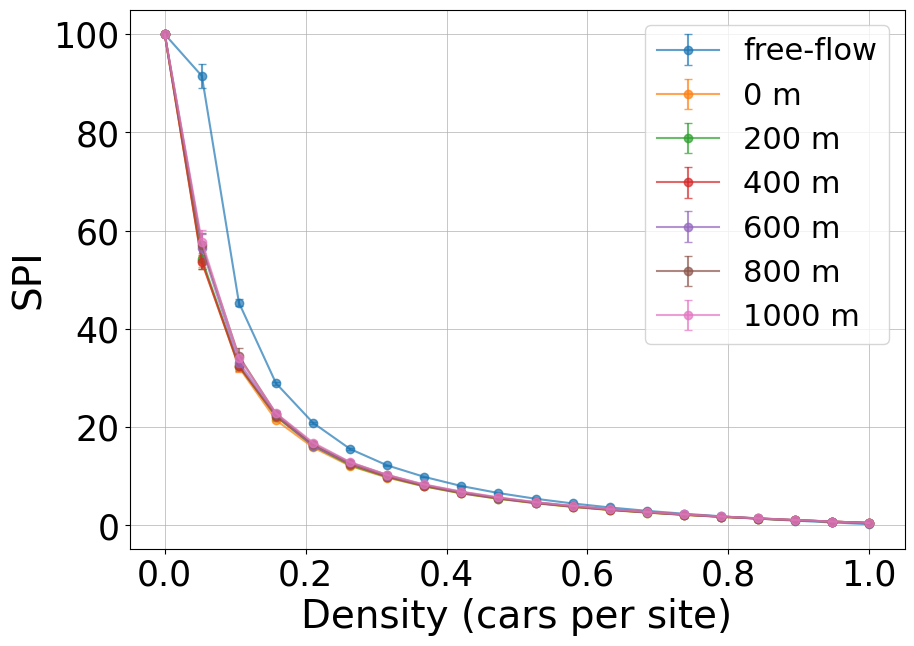

In [32]:
# Plot FR vs density and SPI vs density
data_points = 20
var_speed_labels = ["free-flow", "0 m", "200 m", "400 m", "600 m", "800 m", "1000 m"] # length of middle region

# Plot line plot with error bars representing variance for FRs
plt.figure(figsize=(8.5,7))
for i, mean in enumerate(means_fr_var_speed):
    offset = 1#7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_fr_var_speed[i] )[::offset], alpha=0.7, fmt='-o', 
                 label=f'{var_speed_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("Flow rate", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 21)
plt.grid(which='both', linewidth=0.5)
plt.savefig("var_speed_FR.pdf", dpi = 300)


# Plot line plot with error bars representing variance for SPIs
plt.figure(figsize=(10,7))
for i, mean in enumerate(means_spi_var_speed):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar(np.linspace(0, 1, data_points)[::offset], mean[::offset], 
                 yerr=np.sqrt(vars_spi_var_speed[i] )[::offset] , alpha=0.7, fmt='-o', 
                 label=f'{var_speed_labels[i]}',capsize=3)
plt.xlabel("Density (cars per site)", fontsize = 28)
plt.ylabel("SPI", fontsize = 28)
plt.tick_params("both", labelsize = 25)
leg = plt.legend(fontsize = 22)
plt.grid(which='both', linewidth=0.5)
plt.savefig("var_speed_SPI.pdf", dpi = 300)